## Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets
from sklearn.utils import shuffle

import pandas as pd

import seaborn as sns

In [2]:
##Load the dataset
cov_dataset = datasets.fetch_covtype()

data = cov_dataset['data']
target = cov_dataset['target']
features = cov_dataset['feature_names']

In [3]:
##Check target values
target_df = pd.DataFrame(target, columns = ['Type'])
target_df.Type.unique()

array([5, 2, 1, 7, 3, 6, 4])

## Classifier Config

In [3]:
from qiskit import BasicAer, execute
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, NLocal
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC, PegasosQSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit.algorithms.optimizers import SPSA

from sklearn.svm import SVC
from pylab import cm

import time

seed = 12345
algorithm_globals.random_seed = seed

In [4]:
##Entanglements
entanglements = ['linear', 'circular']

##Codifcation circuits
circuits = ['ZZFearuteMap', 'PauliFeatureMap', 'NLocal']

##QSVM Models
models = ['QSVC', 'PegasosQSVC']

##Feature number
dim = 10

##Paulis for PauliFeatureMap
paulis = ['X', 'Y', 'ZZ']

In [5]:
##NLocal config
params = ParameterVector('n', dim)

#Rotation block:
rot = QuantumCircuit(4)
rot.rz(params[0], 0)
rot.rx(params[1], 1)
rot.ry(params[2], 2)
rot.ry(params[3], 3)

#Entanglement block:
ent = QuantumCircuit(5) 
ent.crx(params[4], 0, 1)
ent.crx(params[5], 2, 3)
ent.cry(params[6], 0, 2)
ent.cry(params[7], 1, 3)
ent.crz(params[8], 1, 2)
ent.crz(params[9], 0, 3)

## Binary Classficaction

In [6]:
##Filter classes to have 2
filtered_data = data[target < 3]
filtered_target = target[target < 3]

In [7]:
##Take amount of data from the filtered data
amount = 6000

filtered_data = np.concatenate((filtered_data[filtered_target==1][:amount], filtered_data[filtered_target==2][:amount]))
filtered_target = np.concatenate((filtered_target[filtered_target==1][:amount], filtered_target[filtered_target==2][:amount]))

filtered_data, filtered_target = shuffle(filtered_data, filtered_target, random_state=0)

### Study data

In [6]:
df = pd.DataFrame(filtered_data, columns = features)
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2909.0,294.0,25.0,182.0,88.0,5144.0,141.0,224.0,219.0,4775.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3044.0,68.0,10.0,492.0,26.0,6633.0,231.0,220.0,121.0,2760.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2669.0,137.0,17.0,30.0,6.0,1776.0,244.0,232.0,111.0,6508.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3069.0,243.0,25.0,808.0,-21.0,4143.0,162.0,250.0,218.0,1198.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2632.0,97.0,8.0,150.0,-10.0,1026.0,233.0,229.0,129.0,5858.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


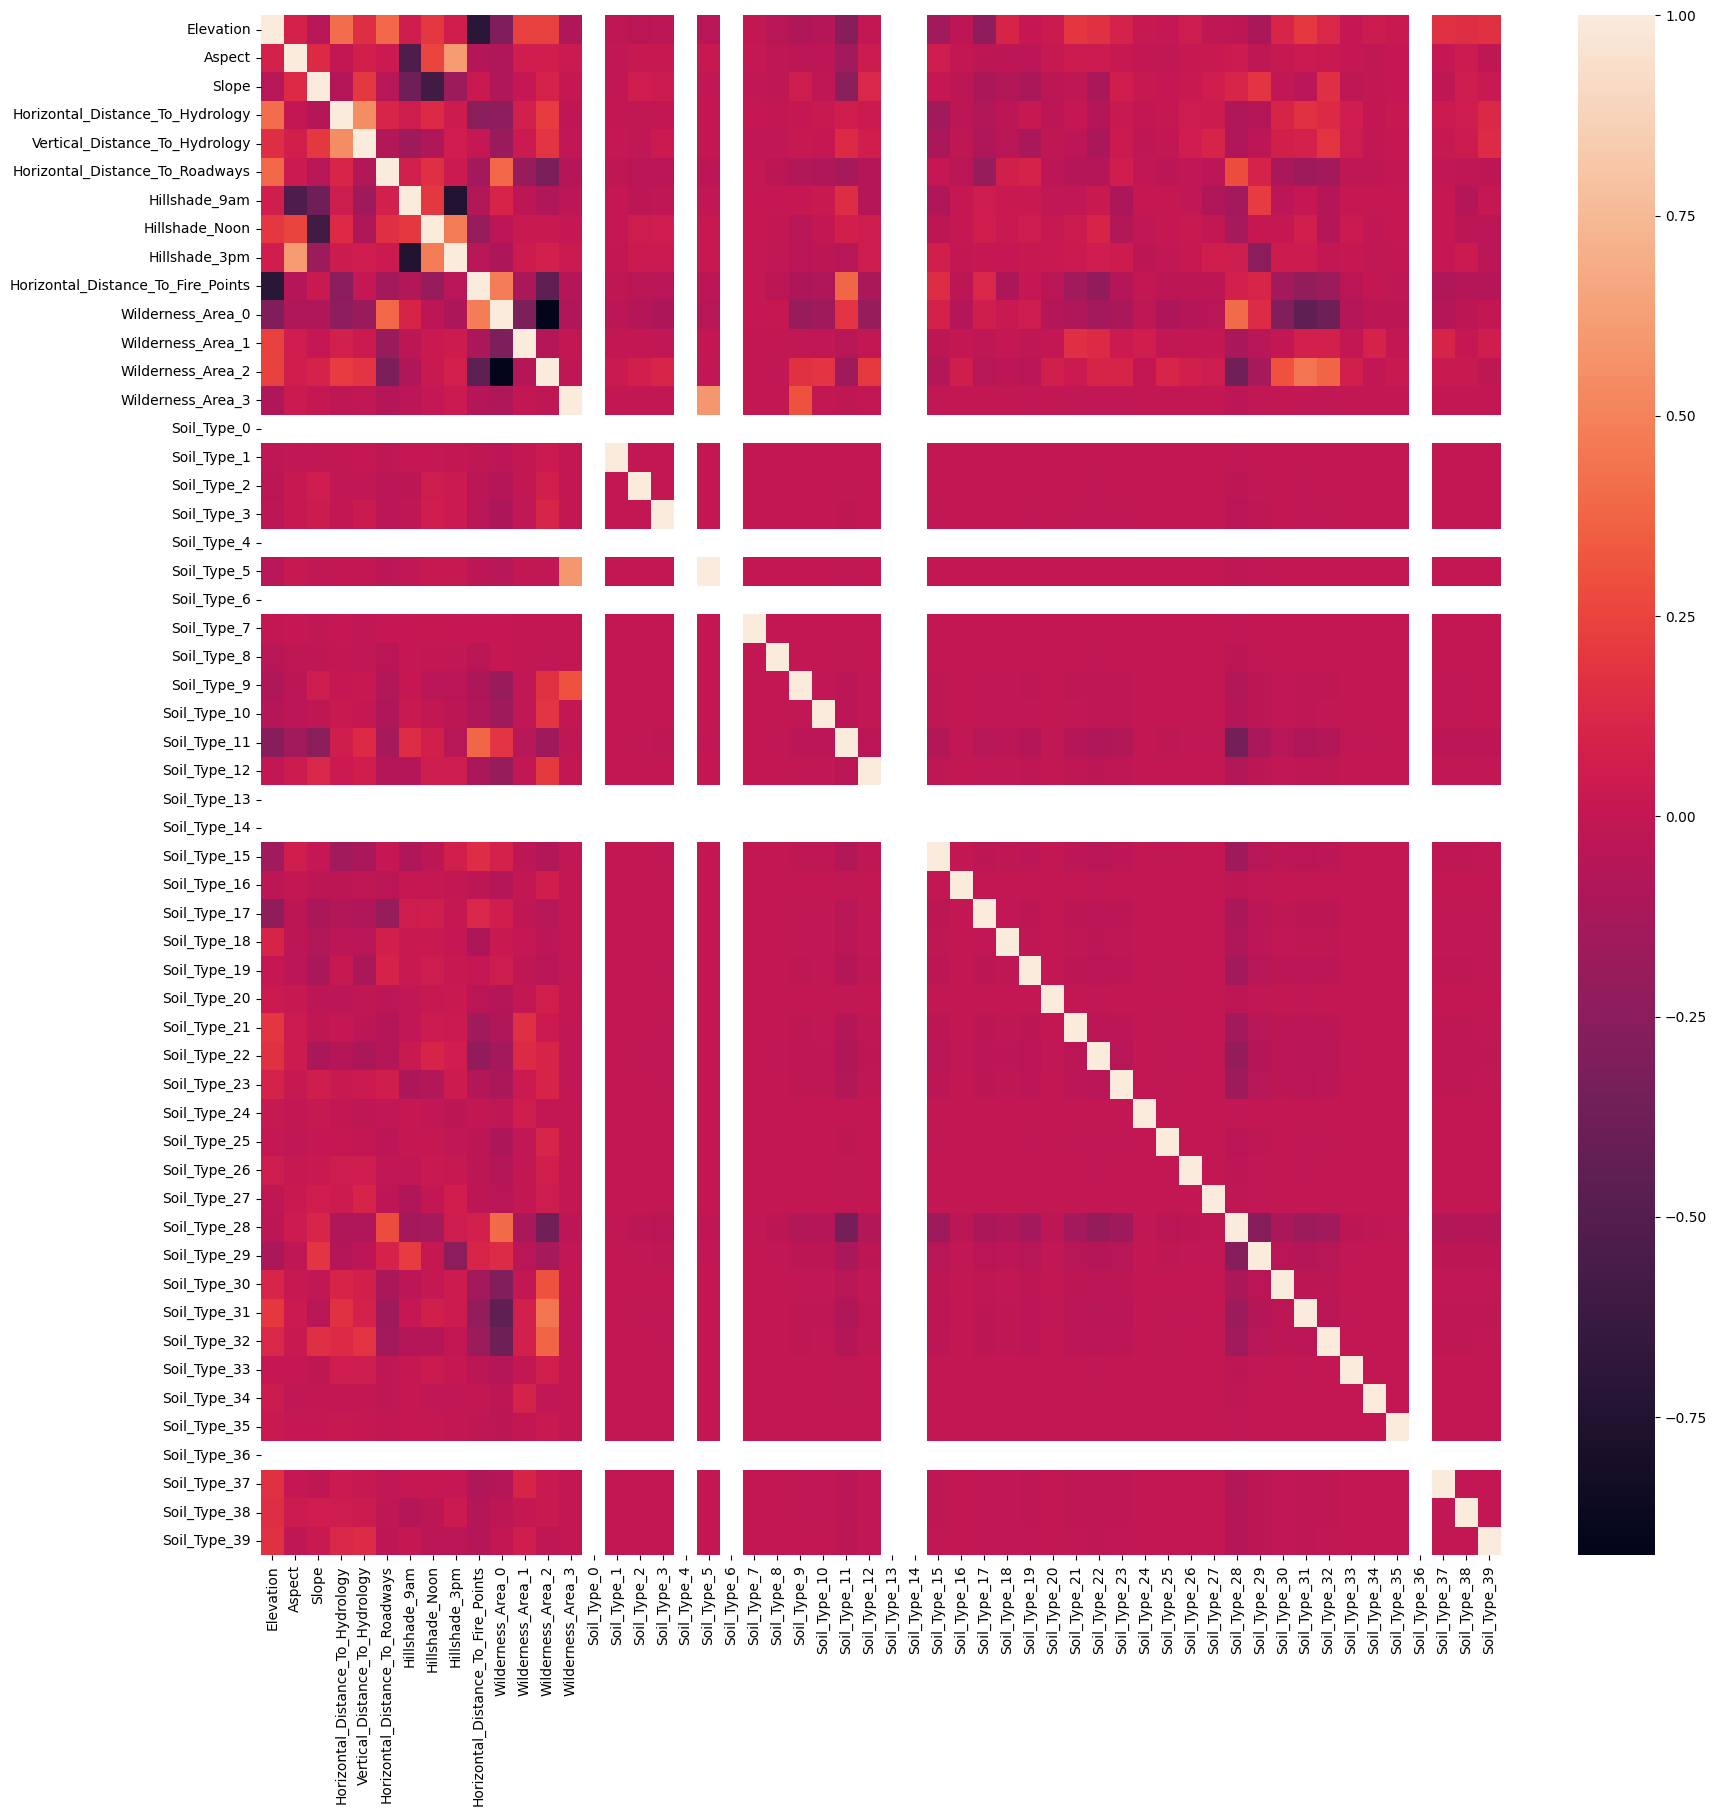

In [7]:
##Plot the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=False) 
plt.show()

### Train the models

In [8]:
sample_train, sample_test, label_train, label_test = train_test_split(filtered_data, filtered_target, test_size=0.2, random_state=22)

#Reduce dimensions
n_dim = dim
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

#Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

#Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

#### Explicita

In [15]:
##QSVC ZZFeatureMap
for entanglement in entanglements + ['full']:
  zz_map = ZZFeatureMap(feature_dimension=dim, reps=2, entanglement=entanglement)
  kernel = QuantumKernel(feature_map=zz_map, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with ZZFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with ZZFeatureMap: {end_time - start_time}")

QSVC linear test score with ZZFeatureMap: 0.8729166666666667
QSVC linear time with ZZFeatureMap: 585.3462147712708
QSVC circular test score with ZZFeatureMap: 0.8783333333333333
QSVC circular time with ZZFeatureMap: 618.6703689098358
QSVC full test score with ZZFeatureMap: 0.84625
QSVC full time with ZZFeatureMap: 1682.2750720977783


In [16]:
##QSVC PauliFeatureMap
for entanglement in entanglements + ['full']:
  map_pauli = PauliFeatureMap(feature_dimension=dim, reps=2, entanglement=entanglement, paulis=paulis)
  kernel = QuantumKernel(feature_map=map_pauli, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  
  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)
  
  print(f"QSVC {entanglement} test score with PauliFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with PauliFeatureMap: {end_time - start_time}")

QSVC linear test score with PauliFeatureMap: 0.855
QSVC linear time with PauliFeatureMap: 639.7012674808502
QSVC circular test score with PauliFeatureMap: 0.8545833333333334
QSVC circular time with PauliFeatureMap: 670.7510762214661
QSVC full test score with PauliFeatureMap: 0.6979166666666666
QSVC full time with PauliFeatureMap: 1724.3661062717438


In [12]:
##QSVC NLocalFeatureMap
for entanglement in entanglements:
  nlocal = NLocal(num_qubits=dim, reps=2, rotation_blocks=rot, entanglement_blocks=ent, entanglement=entanglement, overwrite_block_parameters=False)
  kernel = QuantumKernel(feature_map=nlocal, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with NLocalFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with NLocalFeatureMap: {end_time - start_time}")

QSVC linear test score with NLocalFeatureMap: 0.82875
QSVC linear time with NLocalFeatureMap: 595.8845045566559
QSVC circular test score with NLocalFeatureMap: 0.82625
QSVC circular time with NLocalFeatureMap: 656.9410235881805


#### Segunda version

In [10]:
##QSVC ZZFeatureMap with 3 reps
for entanglement in entanglements:
  zz_map = ZZFeatureMap(feature_dimension=dim, reps=3, entanglement=entanglement)
  kernel = QuantumKernel(feature_map=zz_map, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with ZZFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with ZZFeatureMap: {end_time - start_time}")

QSVC linear test score with ZZFeatureMap: 0.8525
QSVC linear time with ZZFeatureMap: 636.9080638885498
QSVC circular test score with ZZFeatureMap: 0.85875
QSVC circular time with ZZFeatureMap: 659.6244039535522


In [11]:
##QSVC PauliFeatureMap with 3 reps
for entanglement in entanglements:
  map_pauli = PauliFeatureMap(feature_dimension=dim, reps=3, entanglement=entanglement, paulis=paulis)
  kernel = QuantumKernel(feature_map=map_pauli, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  
  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)
  
  print(f"QSVC {entanglement} test score with PauliFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with PauliFeatureMap: {end_time - start_time}")

QSVC linear test score with PauliFeatureMap: 0.8591666666666666
QSVC linear time with PauliFeatureMap: 696.907398223877
QSVC circular test score with PauliFeatureMap: 0.8508333333333333
QSVC circular time with PauliFeatureMap: 724.2630693912506


In [12]:
##QSVC NLocalFeatureMap with 3 reps
for entanglement in entanglements:
  nlocal = NLocal(num_qubits=dim, reps=3, rotation_blocks=rot, entanglement_blocks=ent, entanglement=entanglement, overwrite_block_parameters=False)
  kernel = QuantumKernel(feature_map=nlocal, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with NLocalFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with NLocalFeatureMap: {end_time - start_time}")

QSVC linear test score with NLocalFeatureMap: 0.84875
QSVC linear time with NLocalFeatureMap: 723.8759231567383
QSVC circular test score with NLocalFeatureMap: 0.85
QSVC circular time with NLocalFeatureMap: 785.4058935642242


In [13]:
##QSVC PauliFeatureMap with 4 paulis
for entanglement in entanglements:
  map_pauli = PauliFeatureMap(feature_dimension=dim, reps=2, entanglement=entanglement, paulis=paulis + ['Z'])
  kernel = QuantumKernel(feature_map=map_pauli, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  
  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)
  
  print(f"QSVC {entanglement} test score with PauliFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with PauliFeatureMap: {end_time - start_time}")

QSVC linear test score with PauliFeatureMap: 0.8566666666666667
QSVC linear time with PauliFeatureMap: 648.7500619888306
QSVC circular test score with PauliFeatureMap: 0.86
QSVC circular time with PauliFeatureMap: 673.0269994735718


In [14]:
##NLocal config
params_s = ParameterVector('n', dim)

#Rotation block:
rot_s = QuantumCircuit(4)
rot_s.ry(params_s[0], 0)
rot_s.rz(params_s[1], 1)
rot_s.rx(params_s[2], 2)
rot_s.rx(params_s[3], 3)

#Entanglement block:
ent_s = QuantumCircuit(5) 
ent_s.cry(params_s[4], 0, 1)
ent_s.cry(params_s[5], 2, 3)
ent_s.crz(params_s[6], 0, 2)
ent_s.crz(params_s[7], 1, 3)
ent_s.cry(params_s[8], 1, 2)
ent_s.cry(params_s[9], 0, 3)

##QSVC NLocalFeatureMap with new entanglemente blocks
for entanglement in entanglements:
  nlocal = NLocal(num_qubits=dim, reps=3, rotation_blocks=rot_s, entanglement_blocks=ent_s, entanglement=entanglement, overwrite_block_parameters=False)
  kernel = QuantumKernel(feature_map=nlocal, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with NLocalFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with NLocalFeatureMap: {end_time - start_time}")

QSVC linear test score with NLocalFeatureMap: 0.8595833333333334
QSVC linear time with NLocalFeatureMap: 701.044629573822
QSVC circular test score with NLocalFeatureMap: 0.84875
QSVC circular time with NLocalFeatureMap: 777.2302992343903


In [9]:
##QSVC ZZFeatureMap with 1 reps
for entanglement in entanglements:
  zz_map = ZZFeatureMap(feature_dimension=dim, reps=1, entanglement=entanglement)
  kernel = QuantumKernel(feature_map=zz_map, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with ZZFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with ZZFeatureMap: {end_time - start_time}")

QSVC linear test score with ZZFeatureMap: 0.8941666666666667
QSVC linear time with ZZFeatureMap: 567.3242573738098
QSVC circular test score with ZZFeatureMap: 0.895
QSVC circular time with ZZFeatureMap: 578.9020006656647


In [10]:
##QSVC PauliFeatureMap with 1 reps
for entanglement in entanglements:
  map_pauli = PauliFeatureMap(feature_dimension=dim, reps=1, entanglement=entanglement, paulis=paulis)
  kernel = QuantumKernel(feature_map=map_pauli, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  
  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)
  
  print(f"QSVC {entanglement} test score with PauliFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with PauliFeatureMap: {end_time - start_time}")

QSVC linear test score with PauliFeatureMap: 0.8841666666666667
QSVC linear time with PauliFeatureMap: 575.5862703323364
QSVC circular test score with PauliFeatureMap: 0.8870833333333333
QSVC circular time with PauliFeatureMap: 594.5619988441467


#### Clásica

In [8]:
##Classical
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
  classical_svc = SVC(kernel=kernel)
  start_time = time.time()
  classical_svc.fit(sample_train, label_train)
  end_time = time.time()
  classical_score = classical_svc.score(sample_test, label_test)  

  print(f"QSVC {kernel} test score: {classical_score}")
  print(f"QSVC {kernel} time: {end_time - start_time}")

QSVC linear test score: 0.7508333333333334
QSVC linear time: 1.6090319156646729
QSVC poly test score: 0.8416666666666667
QSVC poly time: 1.4820003509521484
QSVC rbf test score: 0.8445833333333334
QSVC rbf time: 1.589003324508667
QSVC sigmoid test score: 0.5104166666666666
QSVC sigmoid time: 3.138029098510742


## Multiclass classification

In [11]:
##Take amount of data from the filtered data
amount_class = 2000

filtered_data = data[target==1][:amount_class]
filtered_target = target[target==1][:amount_class]

for type_class in [2,3,4,5,6,7]:
  filtered_data = np.concatenate((filtered_data, data[target==type_class][:amount_class]))
  filtered_target = np.concatenate((filtered_target, target[target==type_class][:amount_class]))

filtered_data, filtered_target = shuffle(filtered_data, filtered_target, random_state=0)

### Train the models

In [12]:
sample_train, sample_test, label_train, label_test = train_test_split(filtered_data, filtered_target, test_size=0.2, random_state=22)

#Reduce dimensions
n_dim = 10
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

#Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

#Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

In [50]:
##QSVC ZZFeatureMap
for entanglement in entanglements:
  zz_map = ZZFeatureMap(feature_dimension=dim, reps=2, entanglement=entanglement)
  kernel = QuantumKernel(feature_map=zz_map, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with ZZFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with ZZFeatureMap: {end_time - start_time}")

QSVC linear test score with ZZFeatureMap: 0.6921428571428572
QSVC linear time with ZZFeatureMap: 730.9964480400085
QSVC circular test score with ZZFeatureMap: 0.7271428571428571
QSVC circular time with ZZFeatureMap: 767.0991065502167


In [51]:
##QSVC PauliFeatureMap
for entanglement in entanglements:
  map_pauli = PauliFeatureMap(feature_dimension=dim, reps=2, entanglement=entanglement, paulis=paulis)
  kernel = QuantumKernel(feature_map=map_pauli, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  
  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)
  
  print(f"QSVC {entanglement} test score with PauliFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with PauliFeatureMap: {end_time - start_time}")

QSVC linear test score with PauliFeatureMap: 0.6664285714285715
QSVC linear time with PauliFeatureMap: 776.812028169632
QSVC circular test score with PauliFeatureMap: 0.6778571428571428
QSVC circular time with PauliFeatureMap: 813.4986791610718


In [53]:
##QSVC NLocalFeatureMap
for entanglement in entanglements:
  nlocal = NLocal(num_qubits=dim, reps=2, rotation_blocks=rot, entanglement_blocks=ent, entanglement=entanglement, overwrite_block_parameters=False)
  kernel = QuantumKernel(feature_map=nlocal, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with NLocalFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with NLocalFeatureMap: {end_time - start_time}")

QSVC linear test score with NLocalFeatureMap: 0.6610714285714285
QSVC linear time with NLocalFeatureMap: 773.112028837204
QSVC circular test score with NLocalFeatureMap: 0.6621428571428571
QSVC circular time with NLocalFeatureMap: 823.0320830345154


In [11]:
##Classical
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
  classical_svc = SVC(kernel=kernel)
  start_time = time.time()
  classical_svc.fit(sample_train, label_train)
  end_time = time.time()
  classical_score = classical_svc.score(sample_test, label_test)  

  print(f"QSVC {kernel} test score: {classical_score}")
  print(f"QSVC {kernel} time: {end_time - start_time}")

QSVC linear test score: 0.6575
QSVC linear time: 1.2780299186706543
QSVC poly test score: 0.7346428571428572
QSVC poly time: 1.2270009517669678
QSVC rbf test score: 0.7278571428571429
QSVC rbf time: 1.6140005588531494
QSVC sigmoid test score: 0.2517857142857143
QSVC sigmoid time: 3.994032621383667


In [55]:
##QSVC full ZZFeatureMap
zz_map = ZZFeatureMap(feature_dimension=dim, reps=2, entanglement='full')
kernel = QuantumKernel(feature_map=zz_map, quantum_instance=BasicAer.get_backend('statevector_simulator'))

qsvc_model = QSVC(quantum_kernel=kernel)
start_time = time.time()
qsvc_model.fit(sample_train, label_train)
end_time = time.time()
qsvc_model_score = qsvc_model.score(sample_test, label_test)

print(f"QSVC full test score with ZZFeatureMap: {qsvc_model_score}")
print(f"QSVC full time with ZZFeatureMap: {end_time - start_time}")

QSVC full test score with ZZFeatureMap: 0.5935714285714285
QSVC full time with ZZFeatureMap: 2056.3111453056335


In [56]:
##QSVC full PauliFeatureMap
map_pauli = PauliFeatureMap(feature_dimension=dim, reps=2, entanglement='full', paulis=paulis)
kernel = QuantumKernel(feature_map=map_pauli, quantum_instance=BasicAer.get_backend('statevector_simulator'))


qsvc_model = QSVC(quantum_kernel=kernel)
start_time = time.time()
qsvc_model.fit(sample_train, label_train)
end_time = time.time()
qsvc_model_score = qsvc_model.score(sample_test, label_test)

print(f"QSVC full test score with PauliFeatureMap: {qsvc_model_score}")
print(f"QSVC full time with PauliFeatureMap: {end_time - start_time}")

QSVC full test score with PauliFeatureMap: 0.43
QSVC full time with PauliFeatureMap: 2101.796033143997


#### Segunda version

In [17]:
##QSVC ZZFeatureMap with 3 reps
for entanglement in entanglements:
  zz_map = ZZFeatureMap(feature_dimension=dim, reps=3, entanglement=entanglement)
  kernel = QuantumKernel(feature_map=zz_map, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with ZZFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with ZZFeatureMap: {end_time - start_time}")

QSVC linear test score with ZZFeatureMap: 0.685
QSVC linear time with ZZFeatureMap: 771.9927563667297
QSVC circular test score with ZZFeatureMap: 0.7053571428571429
QSVC circular time with ZZFeatureMap: 810.1520891189575


In [18]:
##QSVC PauliFeatureMap with 3 reps
for entanglement in entanglements:
  map_pauli = PauliFeatureMap(feature_dimension=dim, reps=3, entanglement=entanglement, paulis=paulis)
  kernel = QuantumKernel(feature_map=map_pauli, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  
  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)
  
  print(f"QSVC {entanglement} test score with PauliFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with PauliFeatureMap: {end_time - start_time}")

QSVC linear test score with PauliFeatureMap: 0.6435714285714286
QSVC linear time with PauliFeatureMap: 852.9502084255219
QSVC circular test score with PauliFeatureMap: 0.6360714285714286
QSVC circular time with PauliFeatureMap: 902.283974647522


In [19]:
##QSVC NLocalFeatureMap with 3 reps
for entanglement in entanglements:
  nlocal = NLocal(num_qubits=dim, reps=3, rotation_blocks=rot, entanglement_blocks=ent, entanglement=entanglement, overwrite_block_parameters=False)
  kernel = QuantumKernel(feature_map=nlocal, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with NLocalFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with NLocalFeatureMap: {end_time - start_time}")

QSVC linear test score with NLocalFeatureMap: 0.7171428571428572
QSVC linear time with NLocalFeatureMap: 882.228640794754
QSVC circular test score with NLocalFeatureMap: 0.7135714285714285
QSVC circular time with NLocalFeatureMap: 968.2281713485718


In [20]:
##QSVC PauliFeatureMap with 4 paulis
for entanglement in entanglements:
  map_pauli = PauliFeatureMap(feature_dimension=dim, reps=2, entanglement=entanglement, paulis=paulis + ['Z'])
  kernel = QuantumKernel(feature_map=map_pauli, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  
  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)
  
  print(f"QSVC {entanglement} test score with PauliFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with PauliFeatureMap: {end_time - start_time}")

QSVC linear test score with PauliFeatureMap: 0.6778571428571428
QSVC linear time with PauliFeatureMap: 792.8421590328217
QSVC circular test score with PauliFeatureMap: 0.6878571428571428
QSVC circular time with PauliFeatureMap: 847.5616466999054


In [21]:
##NLocal config
params_s = ParameterVector('n', dim)

#Rotation block:
rot_s = QuantumCircuit(4)
rot_s.ry(params_s[0], 0)
rot_s.rz(params_s[1], 1)
rot_s.rx(params_s[2], 2)
rot_s.rx(params_s[3], 3)

#Entanglement block:
ent_s = QuantumCircuit(5) 
ent_s.cry(params_s[4], 0, 1)
ent_s.cry(params_s[5], 2, 3)
ent_s.crz(params_s[6], 0, 2)
ent_s.crz(params_s[7], 1, 3)
ent_s.cry(params_s[8], 1, 2)
ent_s.cry(params_s[9], 0, 3)

##QSVC NLocalFeatureMap with new entanglemente blocks
for entanglement in entanglements:
  nlocal = NLocal(num_qubits=dim, reps=3, rotation_blocks=rot_s, entanglement_blocks=ent_s, entanglement=entanglement, overwrite_block_parameters=False)
  kernel = QuantumKernel(feature_map=nlocal, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with NLocalFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with NLocalFeatureMap: {end_time - start_time}")

QSVC linear test score with NLocalFeatureMap: 0.7639285714285714
QSVC linear time with NLocalFeatureMap: 873.4960293769836
QSVC circular test score with NLocalFeatureMap: 0.765
QSVC circular time with NLocalFeatureMap: 953.6711146831512


In [13]:
##QSVC ZZFeatureMap with 1 reps
for entanglement in entanglements:
  zz_map = ZZFeatureMap(feature_dimension=dim, reps=1, entanglement=entanglement)
  kernel = QuantumKernel(feature_map=zz_map, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)

  print(f"QSVC {entanglement} test score with ZZFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with ZZFeatureMap: {end_time - start_time}")

QSVC linear test score with ZZFeatureMap: 0.735
QSVC linear time with ZZFeatureMap: 663.7447195053101
QSVC circular test score with ZZFeatureMap: 0.7610714285714286
QSVC circular time with ZZFeatureMap: 691.8360364437103


In [14]:
##QSVC PauliFeatureMap with 1 reps
for entanglement in entanglements:
  map_pauli = PauliFeatureMap(feature_dimension=dim, reps=1, entanglement=entanglement, paulis=paulis)
  kernel = QuantumKernel(feature_map=map_pauli, quantum_instance=BasicAer.get_backend('statevector_simulator'))

  
  qsvc_model = QSVC(quantum_kernel=kernel)
  start_time = time.time()
  qsvc_model.fit(sample_train, label_train)
  end_time = time.time()
  qsvc_model_score = qsvc_model.score(sample_test, label_test)
  
  print(f"QSVC {entanglement} test score with PauliFeatureMap: {qsvc_model_score}")
  print(f"QSVC {entanglement} time with PauliFeatureMap: {end_time - start_time}")

QSVC linear test score with PauliFeatureMap: 0.7332142857142857
QSVC linear time with PauliFeatureMap: 686.0999929904938
QSVC circular test score with PauliFeatureMap: 0.7378571428571429
QSVC circular time with PauliFeatureMap: 712.4549639225006
